In [1]:
!pip install terratorch==0.99.7

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 4.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.0/289.0 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.9/161.9 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 845.1/845.1 kB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.4/27.4 MB 64.7 MB/s eta 0:00:00
   

In [1]:
import os
import numpy as np
import cv2
import torch
import torch.optim as optim

import terratorch
from terratorch.datamodules import Landslide4SenseNonGeoDataModule
from terratorch.datasets import Landslide4SenseNonGeo
from terratorch.tasks import SemanticSegmentationTask

import albumentations
from albumentations import Compose, Flip
from albumentations.pytorch import ToTensorV2

import lightning.pytorch as pl
from lightning.pytorch.loggers import TensorBoardLogger

from huggingface_hub import snapshot_download

wxc_downscaling not installed
wxc_downscaling not installed


In [2]:
import sys
import os

if 'google.colab' in sys.modules:
  import gdown
  if not os.path.isfile('Landslide4sense.zip'):
    gdown.download("https://drive.google.com/uc?id=1Ds_7r4wgeejFM3-f2MdJWBYrPFzAt8-Z")
    !unzip Landslide4sense.zip
  local_path = '.'
else:
  local_path = snapshot_download(repo_id='ibm-nasa-geospatial/Landslide4sense', repo_type="dataset")

Downloading...
From (original): https://drive.google.com/uc?id=1Ds_7r4wgeejFM3-f2MdJWBYrPFzAt8-Z
From (redirected): https://drive.google.com/uc?id=1Ds_7r4wgeejFM3-f2MdJWBYrPFzAt8-Z&confirm=t&uuid=0c75a7d3-6309-4678-a12a-78696fd95463
To: /content/Landslide4sense.zip
100%|██████████| 3.08G/3.08G [00:32<00:00, 95.1MB/s]


Streaming output truncated to the last 5000 lines.
  inflating: annotations/validation/mask_185.h5  
  inflating: annotations/validation/mask_186.h5  
  inflating: annotations/validation/mask_187.h5  
  inflating: annotations/validation/mask_191.h5  
  inflating: annotations/validation/mask_189.h5  
  inflating: annotations/validation/mask_188.h5  
  inflating: annotations/validation/mask_190.h5  
  inflating: annotations/validation/mask_192.h5  
  inflating: annotations/validation/mask_193.h5  
  inflating: annotations/validation/mask_194.h5  
  inflating: annotations/validation/mask_19.h5  
  inflating: annotations/validation/mask_195.h5  
  inflating: annotations/validation/mask_198.h5  
  inflating: annotations/validation/mask_196.h5  
  inflating: annotations/validation/mask_197.h5  
  inflating: annotations/validation/mask_202.h5  
  inflating: annotations/validation/mask_2.h5  
  inflating: annotations/validation/mask_199.h5  
  inflating: annotations/validation/mask_201.h5  
  

# Landslide4Sense Example

In [3]:
DATASET_PATH = local_path #os.path.join('dataset_dir', 'Landslide4sense')

In [4]:
# those are the recommended transforms for this task
transforms = [
    albumentations.HorizontalFlip(),
    albumentations.Flip(),
    albumentations.Resize(224, 224),
    albumentations.pytorch.transforms.ToTensorV2(),
]

In [5]:
# this datamodule allows access to the dataset in its various splits.
datamodule = Landslide4SenseNonGeoDataModule(
    batch_size=16,
    data_root=DATASET_PATH,
    train_transform=transforms,
    val_transform=transforms,
    test_transform=transforms,
)

In [6]:
# checking for the dataset means and stds
datamodule.means, datamodule.stds

([-0.4914,
  -0.3074,
  -0.1277,
  -0.0625,
  0.0439,
  0.0803,
  0.0644,
  0.0802,
  0.3,
  0.4082,
  0.0823,
  0.0516,
  0.3338,
  0.7819],
 [0.9325,
  0.8775,
  0.886,
  0.8869,
  0.8857,
  0.8418,
  0.8354,
  0.8491,
  0.9061,
  1.6072,
  0.8848,
  0.9232,
  0.9018,
  1.2913])

In [7]:
# checking datasets train split size
datamodule.setup("fit")
train_dataset = datamodule.train_dataset
len(train_dataset)

3799

In [8]:
# checking datasets available bands
train_dataset.all_band_names

('COASTAL AEROSOL',
 'BLUE',
 'GREEN',
 'RED',
 'RED_EDGE_1',
 'RED_EDGE_2',
 'RED_EDGE_3',
 'NIR_BROAD',
 'WATER_VAPOR',
 'CIRRUS',
 'SWIR_1',
 'SWIR_2',
 'SLOPE',
 'DEM')

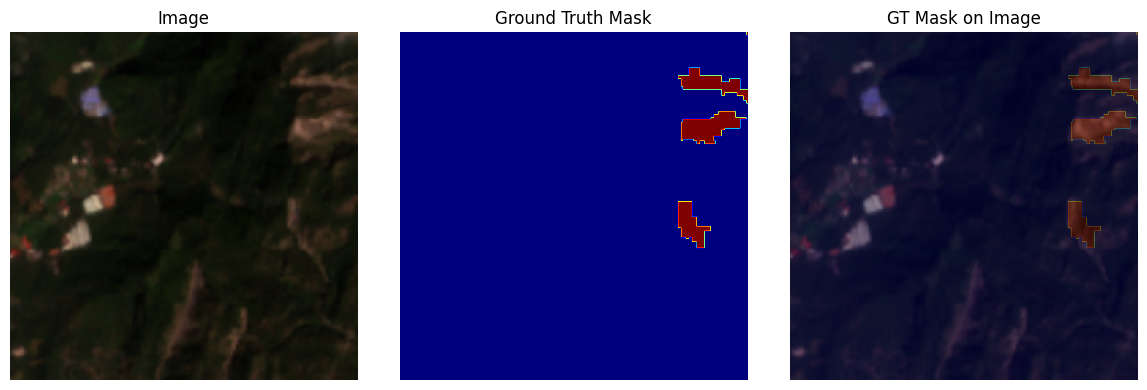

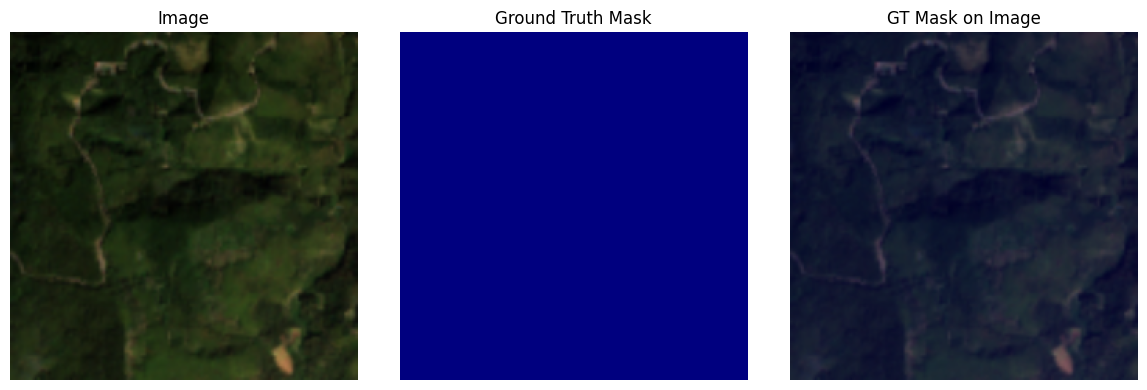

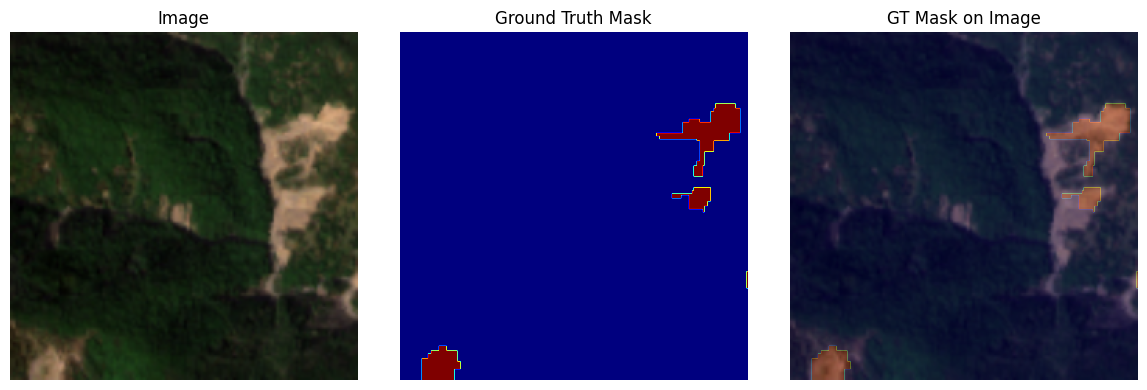

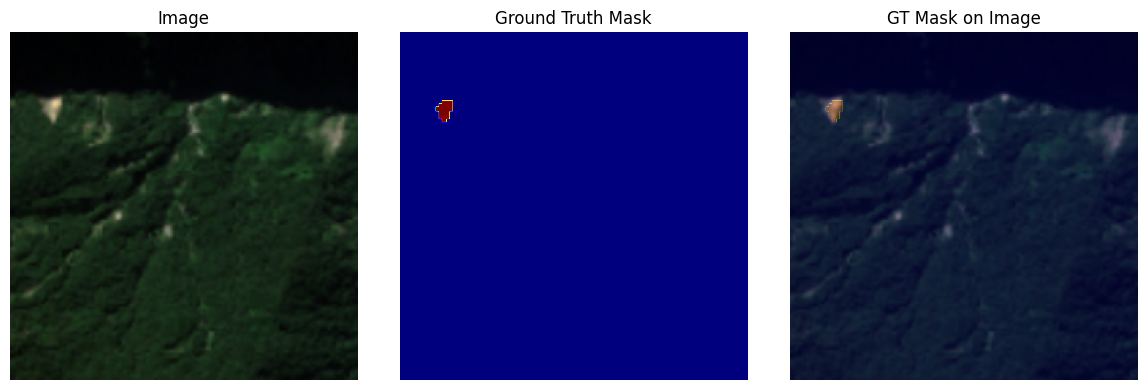

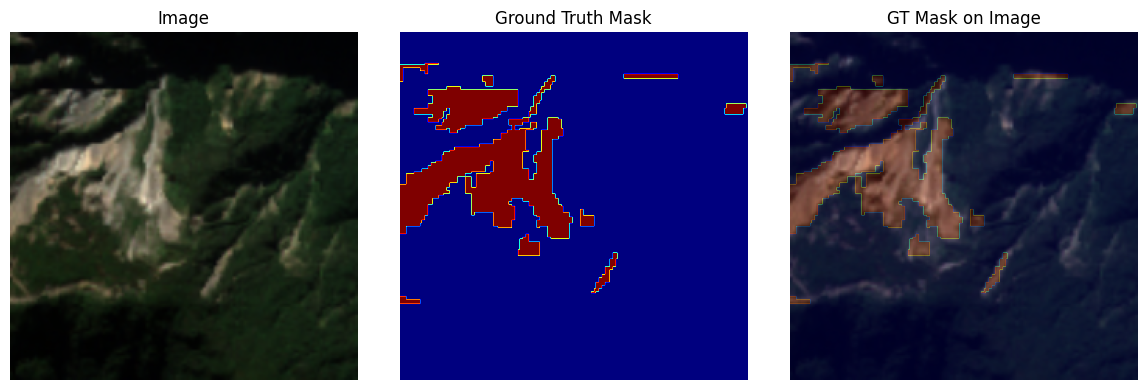

In [9]:
# ploting a few samples
for i in range(5):
    train_dataset.plot(train_dataset[i])

In [10]:
# checking datasets validation split size
val_dataset = datamodule.val_dataset
len(val_dataset)

245

In [11]:
# checking datasets testing split size
datamodule.setup("test")
test_dataset = datamodule.test_dataset
len(test_dataset)

800

In [12]:
pl.seed_everything(0)

# Logger
logger = TensorBoardLogger(
    save_dir="landslide4sense",
    name="tutorial"
)

device = "cuda" if torch.cuda.is_available() else "cpu"

# colab will kill the kernel after ~24 epochs, therefore stopping after two and pull the correct checkpoint after
max_epochs = 2 if 'google.colab' in sys.modules else 50

# Trainer
trainer = pl.Trainer(
    accelerator=device,
    num_nodes=1,
    logger = logger,
    max_epochs=max_epochs,
    check_val_every_n_epoch=2,
    log_every_n_steps=50,
    enable_checkpointing=False,
    default_root_dir="root_dir",
)

# DataModule
data_module = Landslide4SenseNonGeoDataModule(
    batch_size=8,
    bands = ["BLUE", "GREEN", "RED", "NIR_BROAD", "SWIR_1", "SWIR_2"],
    data_root=DATASET_PATH,
    train_transform=transforms,
    val_transform=transforms,
    test_transform=transforms,
)

# Model
model = SemanticSegmentationTask(
    model_args={
        "decoder": "UperNetDecoder",
        "backbone_pretrained": True,
        "backbone": "prithvi_eo_v2_300", # Model can be either prithvi_eo_v2_300, prithvi_eo_v2_300_tl, prithvi_eo_v2_600, prithvi_eo_v2_600_tl
        "backbone_in_channels": 6,
        "rescale": True,
        "backbone_bands": ["BLUE", "GREEN", "RED", "NIR_BROAD", "SWIR_1", "SWIR_2"],
        "backbone_num_frames": 1,
        "num_classes": 2,
        "head_dropout": 0.1,
        "decoder_channels": 256,
        "decoder_scale_modules": True,
        "head_channel_list": [128, 64],
        "necks": [
            {
                "name": "SelectIndices",
                #"indices": [2, 5, 8, 11] # indices for prithvi_vit_100
                "indices": [5, 11, 17, 23] # indices for prithvi_vit_300
                #"indices": [7, 15, 23, 31] # indices for prithvi_vit_600
            },
            {
                "name": "ReshapeTokensToImage"
            }
        ]
    },
    plot_on_val=False,
    loss="focal",
    lr=1.0e-4,
    optimizer="AdamW",
    optimizer_hparams={"weight_decay": 0.1},
    scheduler="StepLR",
    scheduler_hparams={"step_size": 10, "gamma": 0.9},
    ignore_index=-1,
    freeze_backbone=False,
    freeze_decoder=False,
    model_factory="EncoderDecoderFactory",
)

# Training
trainer.fit(model, datamodule=data_module)


INFO: Seed set to 0
INFO:lightning.fabric.utilities.seed:Seed set to 0
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/753 [00:00<?, ?B/s]

Prithvi_EO_V2_300M.pt:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/timm/models/_hub.py:190: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(cached_file, map_location='cpu')
INFO: LOCAL

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


In [13]:
trainer.test(model, datamodule=data_module)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃             Test metric             ┃            DataLoader 0             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test/Multiclass_Accuracy       │          0.982530415058136          │
│      test/Multiclass_F1_Score       │          0.982530415058136          │
│    test/Multiclass_Jaccard_Index    │         0.5338106751441956          │
│ test/Multiclass_Jaccard_Index_Micro │          0.965660572052002          │
│              test/loss              │       1.7936155245479313e-06        │
│      test/multiclassaccuracy_0      │         0.9997905492782593          │
│      test/multiclassaccuracy_1      │         0.08604531735181808         │
│    test/multiclassjaccardindex_0    │         0.9825018644332886          │
│    test/multiclassjaccardindex_1    │         0.08511951565742493         │
└─────────────────────────────────────┴─────────────────────────────────────┘

[{'test/loss': 1.7936155245479313e-06,
  'test/Multiclass_Accuracy': 0.982530415058136,
  'test/multiclassaccuracy_0': 0.9997905492782593,
  'test/multiclassaccuracy_1': 0.08604531735181808,
  'test/Multiclass_F1_Score': 0.982530415058136,
  'test/Multiclass_Jaccard_Index': 0.5338106751441956,
  'test/multiclassjaccardindex_0': 0.9825018644332886,
  'test/multiclassjaccardindex_1': 0.08511951565742493,
  'test/Multiclass_Jaccard_Index_Micro': 0.965660572052002}]

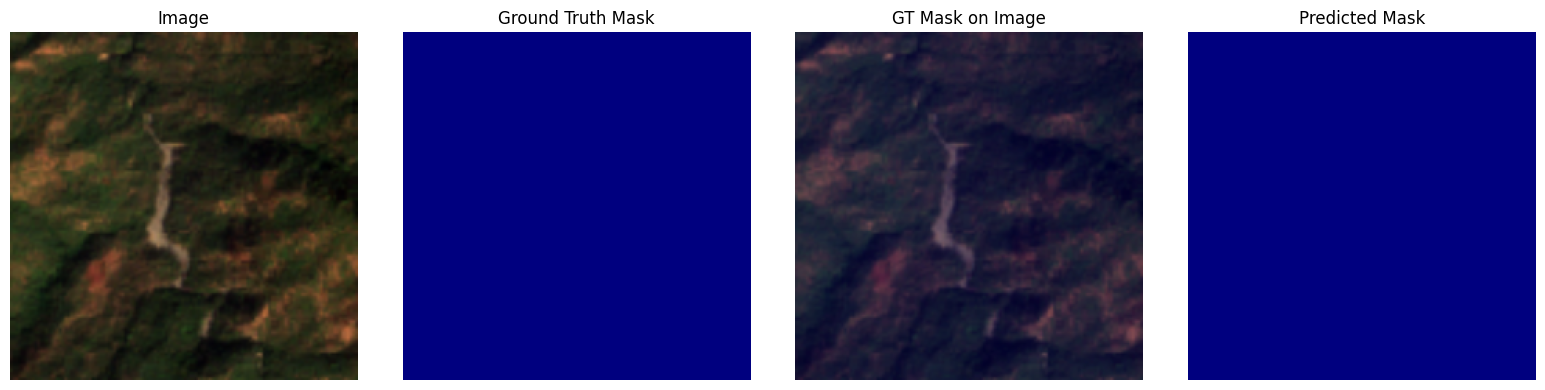

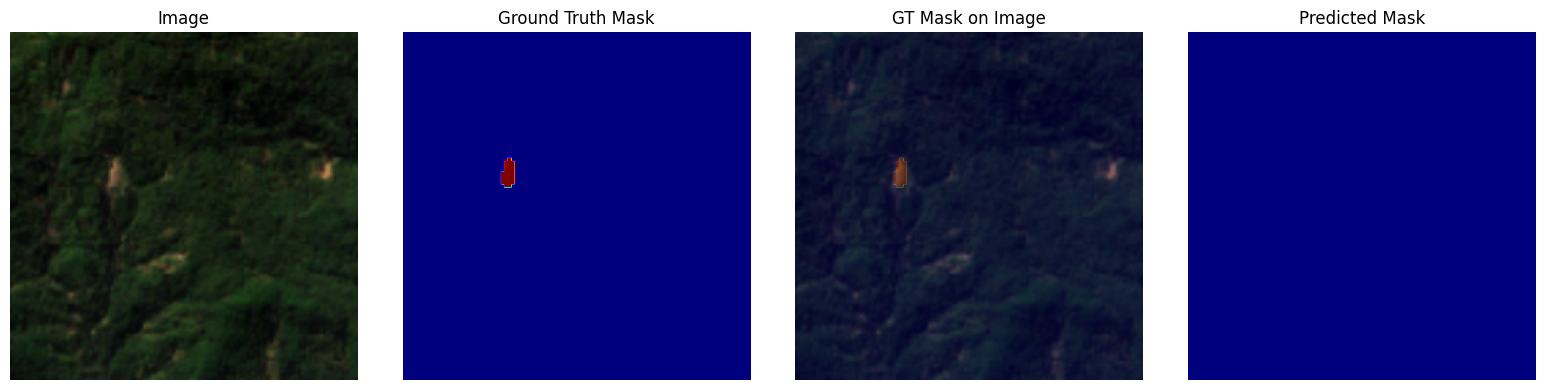

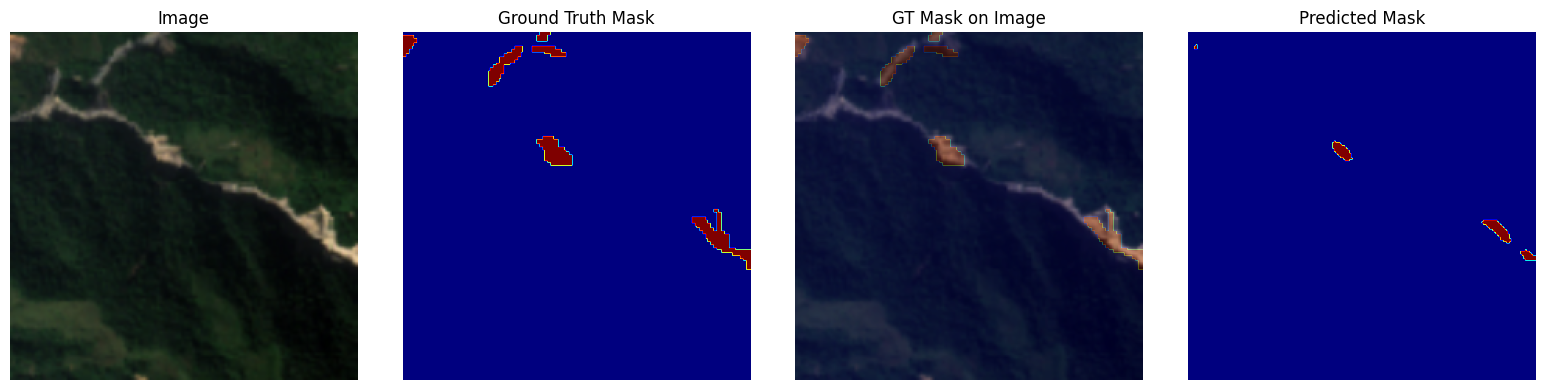

In [14]:
# now we can use the model for predictions and ploting!
test_dataset = data_module.test_dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_loader = data_module.test_dataloader()
model.to(device)
with torch.no_grad():
    batch = next(iter(test_loader))
    images = batch["image"].to(device)
    masks = batch["mask"].to(device)
    other_keys = batch.keys() - {"image", "mask", "filename"}
    rest = {k: batch[k].to(device) for k in other_keys}

    outputs = model(images, **rest)
    preds = torch.argmax(outputs.output, dim=1).cpu().numpy()

for i in range(5,8):
    sample = {key: batch[key][i] for key in batch}
    sample["prediction"] = preds[i]
    test_dataset.plot(sample)